# Import und Hyperparameter


In [7]:
# math
import numpy as np
# tensorflow
%tensorflow_version 2.x
import tensorflow as tf
# visualization
import matplotlib.pyplot as plt
# probabilistic math
import tensorflow_probability as tfp

import time

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization
from tensorflow.keras.activations import relu, sigmoid

In [8]:
#hyperparameters
batch_size = 50
#buffer size
buffer_size = 128
#number of epochs to train the network for 
num_epochs = 50
prefetch_size = 32
#learning rate for weight adjustment
learning_rate = 0.00001
#dimension of random noise
noise_dim = 100

# Loading the data set

## Loading `fashion_mnist`

In [9]:
from keras.datasets import fashion_mnist

(x_train, y_train), (_, _) = fashion_mnist.load_data()

General information on the `fashion_mnist` dataset can be found here: https://github.com/zalandoresearch/fashion-mnist

The keras documentation (https://keras.io/api/datasets/fashion_mnist/ )provides us with information on the output of the module's `load_data` method: 

>**Returns**>
>
>- Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
>- x_train, x_test: uint8 arrays of grayscale image data with shape 
(num_samples, 28, 28).
>- y_train, y_test: uint8 arrays of labels (integers in range 0-9) with shape (num_samples,).




## Previewing the data

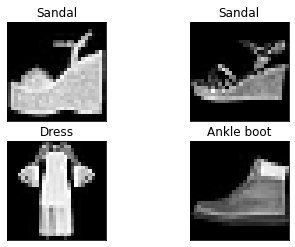

In [10]:
# fashion_mnist labels are integers in range 0-9
# we put the label names in a list in correct order
# (as can be found here https://keras.io/api/datasets/fashion_mnist/)
# so that the integers match the index of the corresponding label name
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# we choose four to be displayed images from the test dataset 
# by randomly determining their indices
a,b,c,d = np.random.randint(low= 0, high= len(x_train)-1, size=4)

fig, axes = plt.subplots(2,2)

axes[0,0].set_title(label_names[y_train[a]])
axes[0,0].imshow(x_train[a],cmap="gray")

axes[0,1].set_title(label_names[y_train[b]])
axes[0,1].imshow(x_train[b],cmap="gray")

axes[1,0].set_title(label_names[y_train[c]])
axes[1,0].imshow(x_train[c],cmap="gray")

axes[1,1].set_title(label_names[y_train[d]])
axes[1,1].imshow(x_train[d],cmap="gray")

for ax in axes.flatten():
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

plt.show()

# Input pipeline and preprocessing

## Normalizing the images

In [11]:
# create normalized images from both data sets

# training images
# normalize
train_images = tf.keras.utils.normalize(x_train)
# add the (redundant) third dimension to the grayscale images to make them compatible with various functions used during training(require dims=4), e.g. for computing the loss
train_images = tf.expand_dims(train_images, axis=3)

## Constructing the dataset

In [12]:

# create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

# batch, shuffle, and prefetch
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size= buffer_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Discriminator

In [13]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    # two convolutional layers reduce the feature map size from 28x28 to 7x7
    self.conv_1 = Conv2D(filters= 64,
                         kernel_size= 3,
                         strides=1,
                         padding='same',
                         # the leaky relu has a small non zero derivative for x < 0. That way inactive neurons still get adjusted
                         activation= tf.nn.leaky_relu
                        )


    self.conv_2 = Conv2D(filters=64,
                         kernel_size=3,
                         # increased stride reduces the size of the feature map
                         strides=1,
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )
    
    self.conv_3 = Conv2D(filters= 64,
                         kernel_size= 2,
                         strides= 2,
                         padding= 'same',
                         activation= tf.nn.leaky_relu
                        )

    self.conv_4 = Conv2D(filters=32,
                         kernel_size=3,
                         strides=1,                     
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )

    self.conv_5 = Conv2D(filters=32,
                         kernel_size=2,
                         strides=2,                     
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )
    
    self.conv_6 = Conv2D(filters=16,
                         kernel_size=3,
                         strides=1,                     
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )

    self.conv_7 = Conv2D(filters=16,
                         kernel_size=3,
                         strides=1,                     
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )
    
    # flatten the feature maps before using a dense layer to create the embedding
    self.globalaverage = tf.keras.layers.GlobalAveragePooling2D()
    
    self.dense = Dense(units=1,
                       activation=sigmoid
                      )
                                                          
  def call(self, x, training=False):
    
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    x = self.conv_5(x)
    x = self.conv_6(x)
    x = self.conv_7(x)
    x = self.globalaverage(x)
    x = self.dense(x)
    
    return x

# Generator

In [14]:
class Generator(tf.keras.Model):
  def __init__(self, num_layers= 2):
    super(Generator, self).__init__()
    # takes 100 random numbers and makes a picture (similar to decoder)
    
    # restore dimensionality to the flattened feature maps from the embedding
    self.dense = Dense(
                       units=49,
                       activation=relu
                      )
    #reshape the random vector to a square "base" image
    self.reshape = tf.keras.layers.Reshape((7,7,1))

    # two transposed convolution layers increase the feature map size from 7x7 back to 28x28
    self.conv_block_1 = []
    for i in range(num_layers):
      self.conv_block_1.append(Conv2DTranspose(filters= 64,
                                               kernel_size= 3,
                                               strides= 1,
                                               padding= 'same'))
      self.conv_block_1.append(BatchNormalization())
      self.conv_block_1.append(tf.keras.layers.LeakyReLU())


    self.conv_t_1 = Conv2DTranspose(filters=64, 
                                    kernel_size=2, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )
    
    self.conv_block_2 = []
    for i in range(num_layers):
      self.conv_block_2.append(Conv2DTranspose(filters= 32,
                                               kernel_size= 3,
                                               strides= 1,
                                               padding= 'same'))
      self.conv_block_2.append(BatchNormalization())
      self.conv_block_2.append(tf.keras.layers.LeakyReLU())


    self.conv_t_2 = Conv2DTranspose(filters=32, 
                                    kernel_size=2, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )

    self.conv_block_3 = []
    for i in range(num_layers):
      self.conv_block_3.append(Conv2DTranspose(filters= 32,
                                               kernel_size= 3,
                                               strides= 1,
                                               padding= 'same'))
      self.conv_block_3.append(BatchNormalization())
      self.conv_block_3.append(tf.keras.layers.LeakyReLU())

    #a bottleneck layer transforms the feature maps back into a single image
    self.bottleneck = Conv2D(
                             filters=1, 
                             kernel_size=3, 
                             padding= 'same', 
                             activation=sigmoid
                            )
  
  def call(self, x, training= False):
    x = self.dense(x)
    x = self.reshape(x)
    for layer in self.conv_block_1:
      x = layer(x, training= training)
    x = self.conv_t_1(x)
    for layer in self.conv_block_2:
      x = layer(x, training= training)
    x = self.conv_t_2(x)
    for layer in self.conv_block_3:
      x = layer(x, training= training)
    x = self.bottleneck(x)
    return x

# Training

## Creating the models

In [15]:
discriminator = Discriminator()
generator = Generator()

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

## Defining the loss

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [19]:
EPOCHS = 20

num_examples_to_generate = 16

## Defining Train functions

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss 


In [21]:
# We generate 4 new images using random noise for the generator and display them
def print_examples():
  noise = tf.random.normal([4, noise_dim])
  generated_images = generator(noise, training=True)
  fig, axes = plt.subplots(2,2)

  axes[0,0].imshow(np.reshape(generated_images[0], (28,28)),cmap="gray")

  axes[0,1].imshow(np.reshape(generated_images[1], (28,28)),cmap="gray")

  axes[1,0].imshow(np.reshape(generated_images[2], (28,28)),cmap="gray")

  axes[1,1].imshow(np.reshape(generated_images[3], (28,28)),cmap="gray")

  for ax in axes.flatten():
      ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

  plt.show()

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    generator_loss = []
    discriminator_loss = []
    for image_batch in dataset:
      (gen, disc) = train_step(image_batch)
      generator_loss.append(gen)
      discriminator_loss.append(disc)


    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_dir)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print (f"Generator loss: {np.mean(generator_loss)}")
    print (f"Discriminator loss: {np.mean(discriminator_loss)}")
    print_examples()


## Training call

Time for epoch 1 is 27.755773305892944 sec
Generator loss: 1.064726710319519
Discriminator loss: 1.0957838296890259


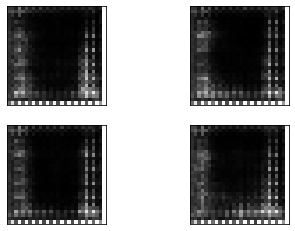

Time for epoch 2 is 19.10768747329712 sec
Generator loss: 2.3163483142852783
Discriminator loss: 0.2777406573295593


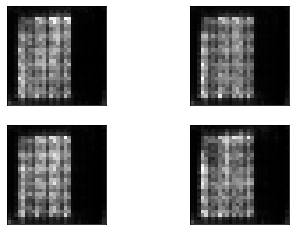

Time for epoch 3 is 19.185043334960938 sec
Generator loss: 0.8185499310493469
Discriminator loss: 1.22370445728302


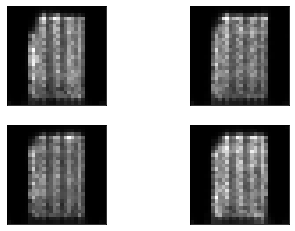

Time for epoch 4 is 19.332847118377686 sec
Generator loss: 0.9378480315208435
Discriminator loss: 1.0495153665542603


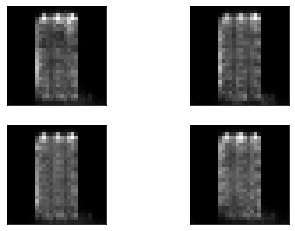

Time for epoch 5 is 19.53020668029785 sec
Generator loss: 1.1786231994628906
Discriminator loss: 0.8245546817779541


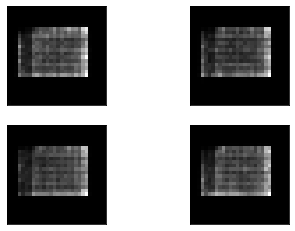

Time for epoch 6 is 19.67182683944702 sec
Generator loss: 1.463442087173462
Discriminator loss: 0.8782963156700134


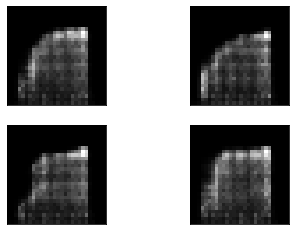

Time for epoch 7 is 19.847036361694336 sec
Generator loss: 0.9192293286323547
Discriminator loss: 1.2864934206008911


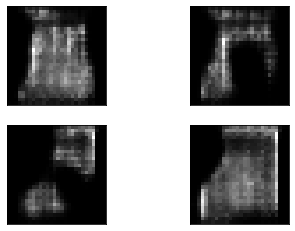

Time for epoch 8 is 19.868491411209106 sec
Generator loss: 0.7971563935279846
Discriminator loss: 1.2756479978561401


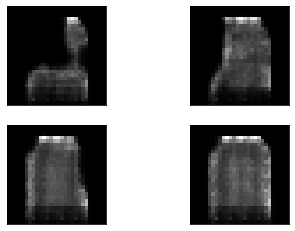

Time for epoch 9 is 19.926658630371094 sec
Generator loss: 0.7683303952217102
Discriminator loss: 1.3585642576217651


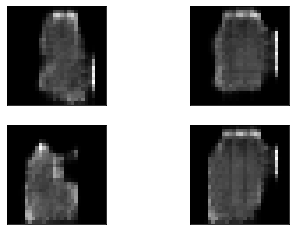

Time for epoch 10 is 20.050618648529053 sec
Generator loss: 0.7513270974159241
Discriminator loss: 1.3224444389343262


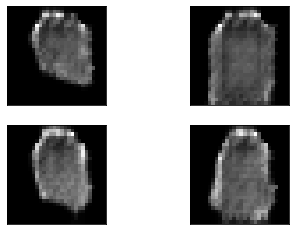

Time for epoch 11 is 20.130550622940063 sec
Generator loss: 0.7650960683822632
Discriminator loss: 1.2879220247268677


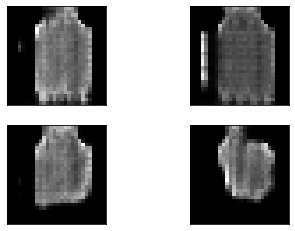

Time for epoch 12 is 20.144684076309204 sec
Generator loss: 0.8287362456321716
Discriminator loss: 1.2026005983352661


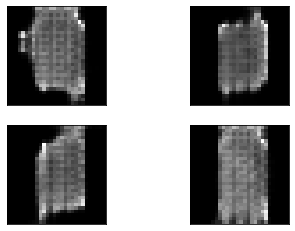

Time for epoch 13 is 20.14260506629944 sec
Generator loss: 0.9309269189834595
Discriminator loss: 1.128063440322876


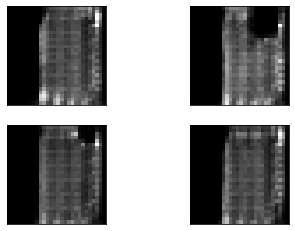

Time for epoch 14 is 20.117843627929688 sec
Generator loss: 1.125565528869629
Discriminator loss: 1.014991283416748


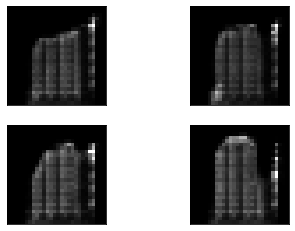

Time for epoch 15 is 20.165875673294067 sec
Generator loss: 0.8612675070762634
Discriminator loss: 1.2251440286636353


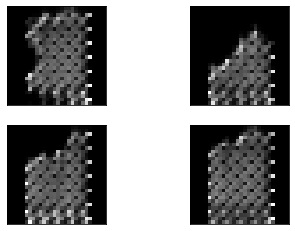

Time for epoch 16 is 20.12459373474121 sec
Generator loss: 0.856083869934082
Discriminator loss: 1.1927363872528076


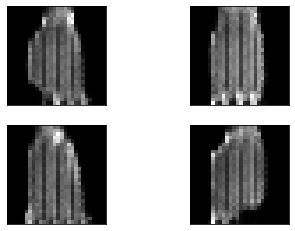

Time for epoch 17 is 20.082937479019165 sec
Generator loss: 1.0297545194625854
Discriminator loss: 1.0365079641342163


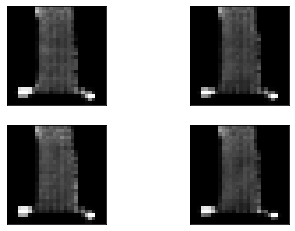

Time for epoch 18 is 20.131184101104736 sec
Generator loss: 1.178981065750122
Discriminator loss: 0.892302930355072


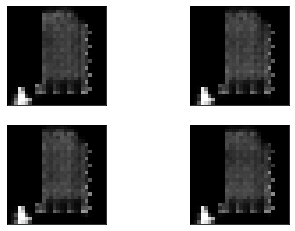

Time for epoch 19 is 20.13579797744751 sec
Generator loss: 1.3515492677688599
Discriminator loss: 0.7285455465316772


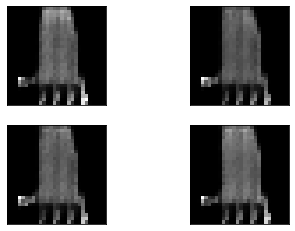

Time for epoch 20 is 20.140095233917236 sec
Generator loss: 1.2234021425247192
Discriminator loss: 0.8540979027748108


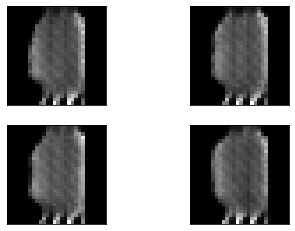

Time for epoch 21 is 20.124449014663696 sec
Generator loss: 0.9000791311264038
Discriminator loss: 1.45710027217865


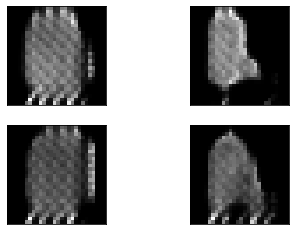

Time for epoch 22 is 20.172579526901245 sec
Generator loss: 0.7891009449958801
Discriminator loss: 1.2922837734222412


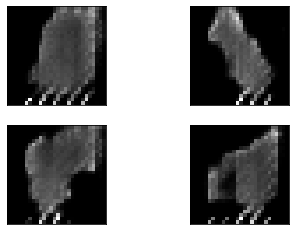

Time for epoch 23 is 20.151978015899658 sec
Generator loss: 0.7608551979064941
Discriminator loss: 1.3291406631469727


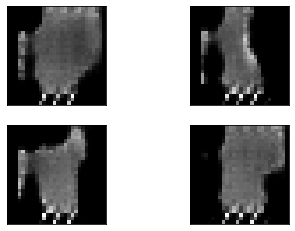

Time for epoch 24 is 20.10873532295227 sec
Generator loss: 0.773605227470398
Discriminator loss: 1.2913861274719238


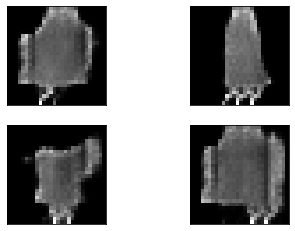

Time for epoch 25 is 20.132545471191406 sec
Generator loss: 0.7840012907981873
Discriminator loss: 1.2665187120437622


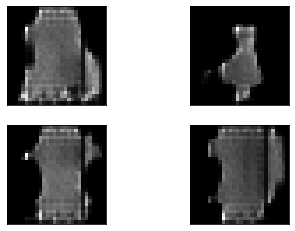

Time for epoch 26 is 20.1724591255188 sec
Generator loss: 0.7913510799407959
Discriminator loss: 1.2684204578399658


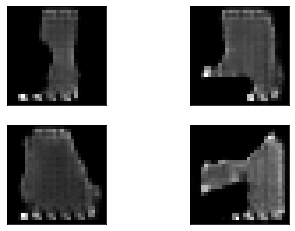

Time for epoch 27 is 20.111767053604126 sec
Generator loss: 0.7943446040153503
Discriminator loss: 1.2641035318374634


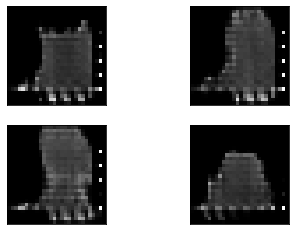

Time for epoch 28 is 20.142488479614258 sec
Generator loss: 0.8123219013214111
Discriminator loss: 1.2736704349517822


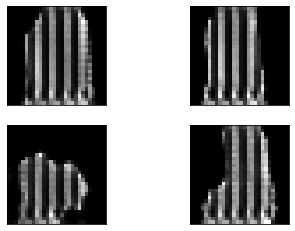

Time for epoch 29 is 20.068926572799683 sec
Generator loss: 0.8097438216209412
Discriminator loss: 1.2816141843795776


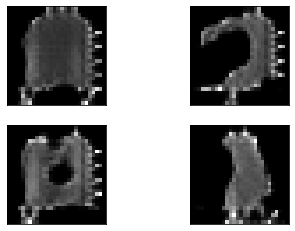

Time for epoch 30 is 20.19064950942993 sec
Generator loss: 0.7740623354911804
Discriminator loss: 1.289757251739502


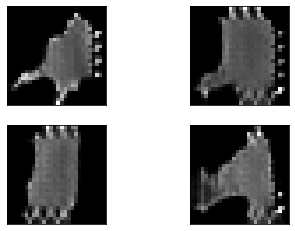

Time for epoch 31 is 20.116272449493408 sec
Generator loss: 0.7764337062835693
Discriminator loss: 1.2922784090042114


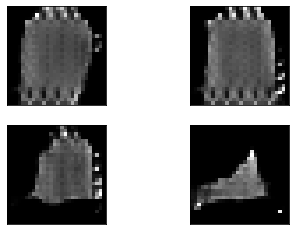

Time for epoch 32 is 20.128647089004517 sec
Generator loss: 0.77433842420578
Discriminator loss: 1.2919631004333496


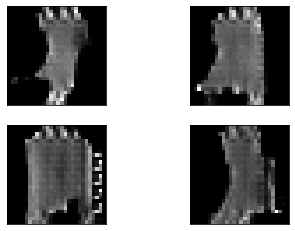

Time for epoch 33 is 20.128995180130005 sec
Generator loss: 0.7675188183784485
Discriminator loss: 1.3040897846221924


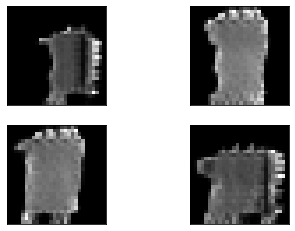

Time for epoch 34 is 20.14075541496277 sec
Generator loss: 0.7610083222389221
Discriminator loss: 1.3126120567321777


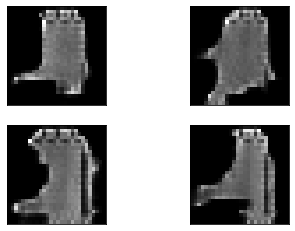

Time for epoch 35 is 20.137791633605957 sec
Generator loss: 0.7625070810317993
Discriminator loss: 1.3069366216659546


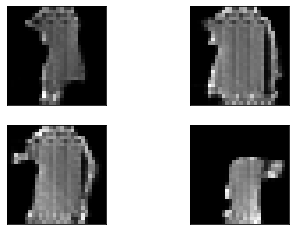

Time for epoch 36 is 20.147093534469604 sec
Generator loss: 0.759566068649292
Discriminator loss: 1.315606713294983


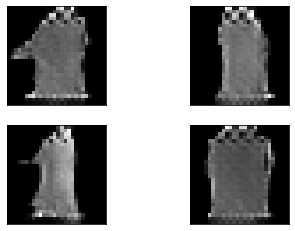

Time for epoch 37 is 20.154022455215454 sec
Generator loss: 0.7633147239685059
Discriminator loss: 1.3098164796829224


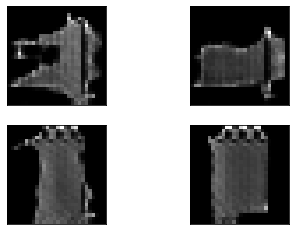

Time for epoch 38 is 20.125276803970337 sec
Generator loss: 0.7684532999992371
Discriminator loss: 1.302088737487793


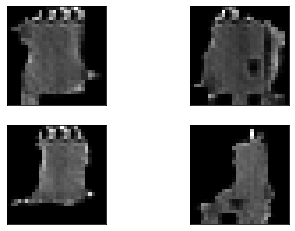

Time for epoch 39 is 20.15117859840393 sec
Generator loss: 0.7612290978431702
Discriminator loss: 1.3084492683410645


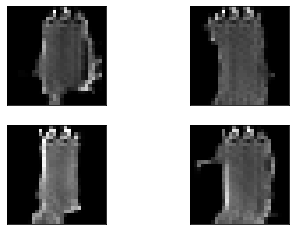

Time for epoch 40 is 20.15907073020935 sec
Generator loss: 0.7624683380126953
Discriminator loss: 1.3084564208984375


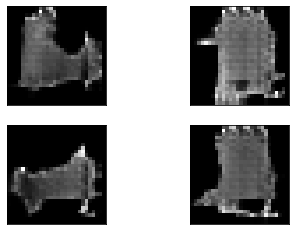

Time for epoch 41 is 20.125833749771118 sec
Generator loss: 0.7575052976608276
Discriminator loss: 1.3192061185836792


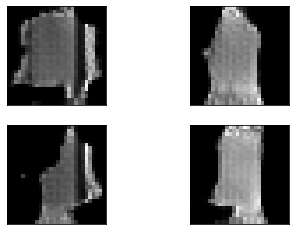

Time for epoch 42 is 20.146231651306152 sec
Generator loss: 0.7537136077880859
Discriminator loss: 1.3212312459945679


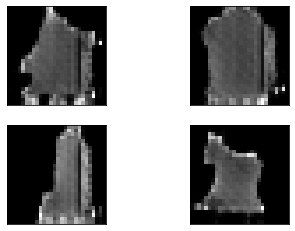

Time for epoch 43 is 20.111466884613037 sec
Generator loss: 0.7563377618789673
Discriminator loss: 1.3165862560272217


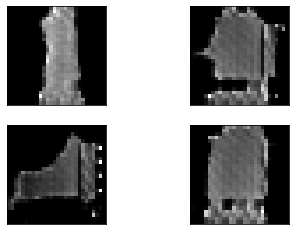

Time for epoch 44 is 20.102705717086792 sec
Generator loss: 0.7423094511032104
Discriminator loss: 1.3416272401809692


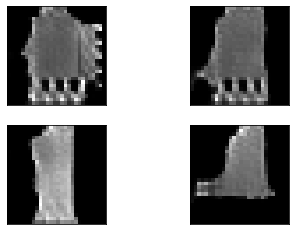

Time for epoch 45 is 20.177079677581787 sec
Generator loss: 0.7420645356178284
Discriminator loss: 1.3402338027954102


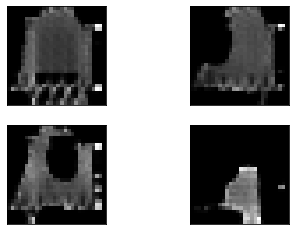

Time for epoch 46 is 20.101500272750854 sec
Generator loss: 0.7468228936195374
Discriminator loss: 1.3261220455169678


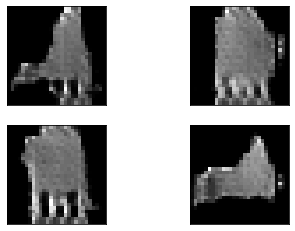

Time for epoch 47 is 20.15878415107727 sec
Generator loss: 0.7459509372711182
Discriminator loss: 1.326220989227295


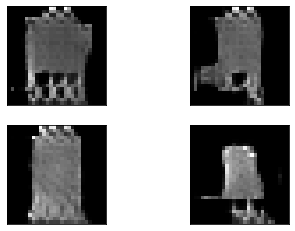

Time for epoch 48 is 20.158629894256592 sec
Generator loss: 0.7432398200035095
Discriminator loss: 1.3302313089370728


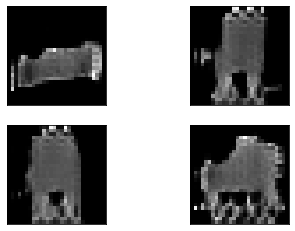

Time for epoch 49 is 20.130662441253662 sec
Generator loss: 0.7419768571853638
Discriminator loss: 1.3294719457626343


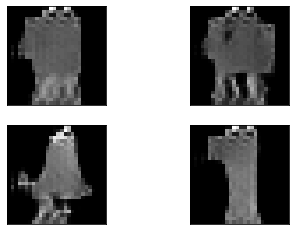

Time for epoch 50 is 20.09806799888611 sec
Generator loss: 0.7424172759056091
Discriminator loss: 1.3342726230621338


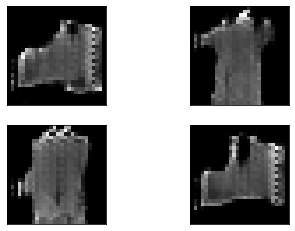

In [23]:
train(train_dataset, num_epochs)

## Results

tf.Tensor(
[[0.50954086]
 [0.47856086]
 [0.5783426 ]
 [0.46973297]], shape=(4, 1), dtype=float32)


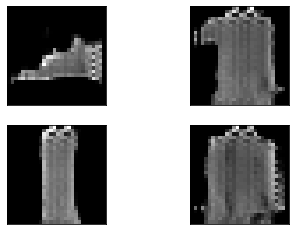

In [24]:
# We generate 4 new images using random noise for the generator and display them
noise = tf.random.normal([4, noise_dim])
generated_images = generator(noise, training=True)
print(discriminator(generated_images))
fig, axes = plt.subplots(2,2)

axes[0,0].imshow(np.reshape(generated_images[0], (28,28)),cmap="gray")

axes[0,1].imshow(np.reshape(generated_images[1], (28,28)),cmap="gray")

axes[1,0].imshow(np.reshape(generated_images[2], (28,28)),cmap="gray")

axes[1,1].imshow(np.reshape(generated_images[3], (28,28)),cmap="gray")

for ax in axes.flatten():
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

plt.show()